# Create SYNTHETIC dataset

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import numpy
import torch 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from MODULES.namedtuple import BB
from MODULES.cropper_uncropper import Uncropper
from MODULES.non_max_suppression import NonMaxSuppression
from MODULES.utilities_visualization import show_batch, plot_img_and_seg
from MODULES.utilities import save_obj, load_obj
from MODULES.utilities_ml import SpecialDataSet  

# Helper functions

In [6]:
def torch_dilation(img, times: int=1):
    tmp = img.flatten(start_dim=0, end_dim=-4)
    for n in range(times):
        tmp = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)(tmp)
    return tmp.view_as(img)

def make_background_grid(n):
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    rotated_bg = numpy.zeros((n,1,width_big,height_big))
    
    angles = numpy.random.rand(n)*45
    for i in range(n):
        angle = numpy.random.rand(1)*45
        dx,dy = (10+10*numpy.random.rand(2)).astype(int)
        template = numpy.zeros((2*width_big,2*height_big))
        template[::dx,:]=1
        template[:,::dy]=1
        tmp = skimage.transform.rotate(template, angle, resize=False, center=None, order=1, clip=True, preserve_range=True)
        rotated_bg[i,0] = tmp[width_big//2:width_big//2+width_big,height_big//2:height_big//2+height_big]
    return torch.from_numpy(rotated_bg)


def make_single_disks(disk_size=28,n_disk=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=disk_size).view(-1,1).expand(disk_size,disk_size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = (r2<1.0).float()
    fake_labels = disk.new_zeros(n_disk)
    return disk[None,None,...].expand(n_disk,-1,-1,-1),fake_labels


def make_single_disks_with_shading(disk_size=28,n_disk=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=disk_size).view(-1,1).expand(disk_size,disk_size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = torch.exp(-r2)*(r2<1.0).float()
    fake_labels = disk.new_zeros(n_disk)
    return disk[None,None,...].expand(n_disk,-1,-1,-1),fake_labels


def create_dataset(params, dataset_single_objects, n_for_class=100):
    batch_size = 64
    n_max_objects = params["N_MAX_OBJECTS"]
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    min_size = params["MIN_OBJECT_SIZE"]
    max_size = params["MAX_OBJECT_SIZE"]
    min_n_obj = params["N_MIN_OBJECTS"]
    max_n_obj = params["N_MAX_OBJECTS"]
    
    dataloader = torch.utils.data.DataLoader(dataset_single_objects, 
                                             batch_size=batch_size*2*n_max_objects, shuffle=True)
    
    uncropper = Uncropper()
    nms = NonMaxSuppression()
    
    goal_for_class = torch.ones(1 + max_n_obj) * n_for_class
    goal_for_class[:min_n_obj] = 0
    n_goal = torch.sum(goal_for_class).int().item()
    data_imgs = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.float)
    data_seg = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.uint8)
    data_count = torch.zeros(n_goal, dtype=torch.uint8)
    
    n_current = 0
    while n_current <  n_goal:
        
        # Generate the small objects
        objects, labels = next(iter(dataloader))
        small_objects = objects.view(-1,batch_size,1,28,28)
        labels = labels.view(-1,batch_size) + 1
        
        # Generate the random locations and scores
        random = torch.rand([4]+list(small_objects.shape[:2]))
        tp, tx, ty, tsize = torch.split(random, 1, dim=0)         
        fake_score = tp.squeeze(0)
        bw_dimfull = min_size + (max_size-min_size) * tsize.squeeze(0)
        bh_dimfull = bw_dimfull
        bx_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*tx.squeeze(0)
        by_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*ty.squeeze(0)
        bounding_box = BB(bx=bx_dimfull, by=by_dimfull, bw=bw_dimfull, bh=bh_dimfull)
      
        # Uncrop 
        big_objects = uncropper.uncrop(bounding_box, small_objects, width_big, height_big)
        
        # Compute non-Max-Suppression
        nms_output: NMSoutput = nms.compute_mask_and_index(score=fake_score,
                                                           bounding_box=bounding_box,
                                                           overlap_threshold=params["OVERLAP_THRESHOLD"],
                                                           n_objects_max=n_max_objects,
                                                           topk_only=False)
        
        # Select non-overlapping object 
        index_select = nms_output.index_top_k[...,None,None,None].expand([n_max_objects]+list(big_objects.shape[-4:])) 
        obj_selected = torch.gather(big_objects, dim=0, index=index_select)  #n_max_objects, batch_size, 1, width_big, height_big
        label_selected = torch.gather(labels.view(-1,batch_size), dim=0, index=nms_output.index_top_k).to(torch.uint8)
        c_selected_old = torch.gather(nms_output.nms_mask, dim=0, index=nms_output.index_top_k).to(torch.uint8)
        
        # Drop some object to achieve balanced class
        counter_for_class = torch.bincount(data_count, minlength=1 + max_n_obj)
        c_selected = drop_some_objects(c_selected_old, counter_for_class, goal_for_class)

        # Compute foreground, labels, counts
        obj_selected_no_overlap = obj_selected * c_selected[...,None,None,None]
        label_selected_no_overlap = label_selected * c_selected
        tmp = (obj_selected_no_overlap > 0.5) * label_selected_no_overlap[...,None,None,None]
        
        count_label = torch.sum(c_selected, dim=0).to(torch.uint8)
        seg_mask = torch.max(torch_dilation(tmp.float(), times=2), dim=0)[0].to(torch.uint8)
        fg = torch.sum(obj_selected_no_overlap, dim=-5).clamp_(max=1.0)
        
        #print(fg.shape, seg_mask.shape, count_label.shape)
        #print(fg.dtype, seg_mask.dtype, count_label.dtype)
         
        # Add to the dataset
        use_this = (count_label > 0)
        dn_max = n_goal-n_current
        dn_available = torch.sum(use_this)
        dn = min(dn_max, dn_available)
        data_imgs[n_current:n_current+dn] = fg[use_this][:dn]
        data_seg[n_current:n_current+dn] = seg_mask[use_this][:dn]
        data_count[n_current:n_current+dn] = count_label[use_this][:dn]
        n_current += dn
    return data_imgs, data_seg, data_count
    

def drop_some_objects(c_selected_old, counter_for_class, goal_for_class):
    """ drop some object by changing the indicator function.
        It start greedely from the most object and remove object 1by1
    """
        
    count = torch.sum(c_selected_old, dim=0)
    available_for_class = torch.bincount(count, minlength=counter_for_class.shape[0]).int()
    missing_for_class = (goal_for_class - counter_for_class).clamp(min=0).int()
    drop_for_class = (available_for_class - missing_for_class).clamp(min=0)
    #print("missing_for_class ---->",missing_for_class)
    #print("available_for_class -->",available_for_class,"-->",torch.sum(available_for_class))
    #print("drop_for_class ------->",drop_for_class)
    
    for cl in range(drop_for_class.shape[0]-1,0,-1): # count backward
        n_dropped = 0
        while drop_for_class[cl] > n_dropped:
            # If there is something to do. I will loop over everything and drop stuff
            for i in range(count.shape[0]):
                if count[i]==cl:
                    index = torch.argmax(c_selected_old[:,i].int(), dim=0)
                    c_selected_old[index,i] = 0
                    n_dropped += 1
                    if (n_dropped == drop_for_class[cl]):
                        return drop_some_objects(c_selected_old, counter_for_class, goal_for_class)
    return c_selected_old       

# Create Multi-MNIST dataset

In [7]:
params = {
    "N_MIN_OBJECTS": 2,
    "N_MAX_OBJECTS": 6,
    "MIN_OBJECT_SIZE": 20,
    "MAX_OBJECT_SIZE": 40,
    "WIDTH_RAW_IMAGE": 80,
    "HEIGHT_RAW_IMAGE": 80,
    "OVERLAP_THRESHOLD" : 0.3
    }

In [8]:
write_dir_single_MNIST = "./"
transform = transforms.ToTensor()
mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

img, seg_mask, count = create_dataset(params, mnist_trainset, n_for_class=1000)
save_obj((img, seg_mask, count), "./multi_mnist_train.pt")
img, seg_mask, count = create_dataset(params, mnist_testset, n_for_class=100)
save_obj((img, seg_mask, count), "./multi_mnist_test.pt")

In [10]:
img, seg_mask, count = create_dataset(params, mnist_trainset, n_for_class=10)
save_obj((img, seg_mask, count), "./SMALL_multi_mnist_train.pt")
img, seg_mask, count = create_dataset(params, mnist_testset, n_for_class=10)
save_obj((img, seg_mask, count), "./SMALL_multi_mnist_test.pt")

### Test the dataloader

Dataset lenght: 50
img.shape torch.Size([50, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes seg.shape labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.) tensor(1.)


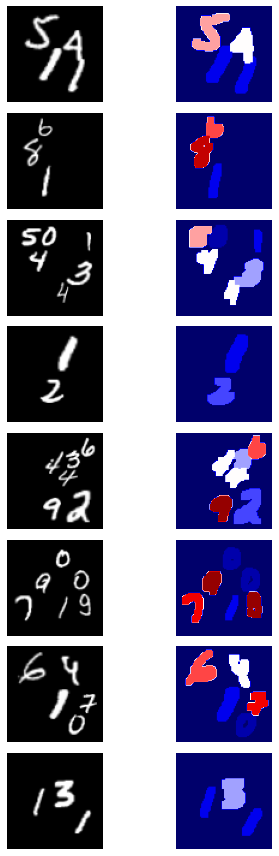

In [11]:
loader = SpecialDataSet(img=img, roi_mask=None, seg_mask=seg_mask, labels=count, batch_size=4, drop_last=False)
loader.check_batch()

In [17]:
a = [1,2,3,4,5]
print(type(a))

b = numpy.array(a)
print(type(b))

<class 'list'>
<class 'numpy.ndarray'>


In [14]:
value = torch.arange(12)
for i, x in enumerate(value):
    print(x.item())

0
1
2
3
4
5
6
7
8
9
10
11


In [20]:
blacklist = ["aaa", "bbb"]
key = "aaa"
if key in blacklist:
    print("skip")

skip


In [12]:
loader.img.shape[0]

50

In [ ]:
img, seg, counts, index = loader.load(index=torch.arange(8))

In [ ]:
torch.sum(img>0.1).float()/torch.numel(img)

In [ ]:
torch.sum(img>0)

In [ ]:
show_batch(img)

In [ ]:
print(img.shape)
print(seg.shape)
print(counts)

In [ ]:
plot_img_and_seg(img[:2], seg_mask[:2], figsize=(6,6))

# Create MNIST dataset

In [ ]:
fg, label, count = create_dataset(params, mnist_trainset, n_for_class=10)
print(" --->",fg.shape, label.shape, count.shape)

In [ ]:
show_batch(label[:8].float())

In [ ]:
print(count[:8])
print(torch.bincount(label[:8].view(-1).int()))
show_batch(fg[:8], cmap='inferno')

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12,12))
for n in range(5):
    axes[n, 0].imshow(label[n, 0].int(), cmap="inferno")
    axes[n, 1].imshow(fg[n,0], cmap="gray")
    show_batch(label[:8].float())

### Save dataset

In [ ]:
disks_with_shading,labels = make_single_disks_with_shading(disk_size=28,n_disk=400)
disks_with_shading_trainset = torch.utils.data.TensorDataset(disks_with_shading,labels)
disks_with_shading_testset = torch.utils.data.TensorDataset(disks_with_shading,labels)

In [ ]:
write_dir_single_MNIST = "./"
transform = transforms.ToTensor()
mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

In [ ]:
fg, label, count = create_dataset(params, mnist_trainset, n_for_class=10)


print(" --->",fg.shape, label.shape, count.shape)

In [ ]:
torch.bincount(count)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,12))
for n in range(4):
    axes[n, 0].imshow(skimage.color.label2rgb(label=label[n, 0].cpu().numpy(),
                                              image=fg[n,0].cpu().numpy(),
                                              alpha=0.5,
                                              bg_label=0))
    axes[n, 1].imshow(fg[n,0])
    
    
    show_batch(label[:8].float())

In [ ]:
show_batch(fg[:8])

In [ ]:
import skimage.color
n=0
print(count[n])
plt.imshow(skimage.color.label2rgb(label=label[n,0].cpu().numpy(),
                                   image=fg[n,0].cpu().numpy(),
                                   alpha=1.0,
                                   bg_label=0))

### Single MNIST dataset and Single DISK dataset

In [ ]:
#write_dir_single_MNIST = "/home/ldalessi/MNIST_DATA/"
write_dir_single_MNIST = "/home/ldalessi/DATA/SINGLE_MNIST/"

#transform = transforms.ToTensor()
#mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
#mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

#disks,labels = make_single_disks(disk_size=28,n_disk=400)
#disks_trainset = torch.utils.data.TensorDataset(disks,labels)
#disks_testset = torch.utils.data.TensorDataset(disks,labels)

disks_with_shading,labels = make_single_disks_with_shading(disk_size=28,n_disk=400)
disks_with_shading_trainset = torch.utils.data.TensorDataset(disks_with_shading,labels)
disks_with_shading_testset = torch.utils.data.TensorDataset(disks_with_shading,labels)

In [ ]:
#write_dir_single_MNIST = "/home/ldalessi/MNIST_DATA/"
write_dir_single_MNIST = "/home/ldalessi/DATA/SINGLE_MNIST/"

#transform = transforms.ToTensor()
#mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
#mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

#disks,labels = make_single_disks(disk_size=28,n_disk=400)
#disks_trainset = torch.utils.data.TensorDataset(disks,labels)
#disks_testset = torch.utils.data.TensorDataset(disks,labels)

disks_with_shading,labels = make_single_disks_with_shading(disk_size=28,n_disk=400)
disks_with_shading_trainset = torch.utils.data.TensorDataset(disks_with_shading,labels)
disks_with_shading_testset = torch.utils.data.TensorDataset(disks_with_shading,labels)

### Create the MULTI OBJECT DATASET from SINGLE OBJECT DATASET

In [ ]:
#multi_mnist_train = create_dataset(params,mnist_trainset,N_imgs=60000)  
#multi_mnist_test = create_dataset(params,mnist_testset,N_imgs=1000) 

#multi_mnist_train = create_dataset(params,mnist_trainset,N_imgs=10)  
#multi_mnist_test = create_dataset(params,mnist_testset,N_imgs=10) 

#multi_disk_train = create_dataset(params,disks_trainset,N_imgs=10)  
#multi_disk_test = create_dataset(params,disks_testset,N_imgs=10) 

#multi_disk_train = create_dataset(params,disks_trainset,N_imgs=2000)  
#multi_disk_test = create_dataset(params,disks_testset,N_imgs=500) 

multi_disk_with_shading_train = create_dataset(params,disks_with_shading_trainset,N_imgs=2000)  
multi_disk_with_shading_test = create_dataset(params,disks_with_shading_testset,N_imgs=500)  

In [ ]:
imgs,labels = multi_disk_with_shading_train
print("imgs.shape",imgs.shape)
print("labels",labels[:8])
show_batch(imgs[:8])

In [ ]:
#imgs,labels = multi_disk_train
#print("imgs.shape",imgs.shape)
#print("labels",labels[:8])
#show_batch(imgs[:8])

In [ ]:
#imgs,labels = multi_mnist_train
#print("imgs.shape",imgs.shape)
#print("labels.shape",labels.shape)
#print("labels",labels[:8])
#show_batch(imgs[:8])

### Save dataset on file

In [ ]:
#write_dir_multiple_MNIST = "/home/ldalessi/MULTI_MNIST/"
#write_dir_multiple_MNIST = "/home/ldalessi/DATA/MULTI_MNIST/"

#save_obj(multi_mnist_train,write_dir_multiple_MNIST,"multi_mnist_train_large")
#save_obj(multi_mnist_test,write_dir_multiple_MNIST,"multi_mnist_test_large")


write_dir_multiple_DISK = "/home/ldalessi/MULTI_MDISK/"
write_dir_multiple_DISK = "/home/ldalessi/DATA/MULTI_DISK/"
write_dir_multiple_DISK = "/Users/ldalessi/DAPI_unsupervised/DATA/DISK_SHADING/"


#save_obj(multi_disk_train,write_dir_multiple_DISK,"multi_disk_train_with_bg")
#save_obj(multi_disk_test,write_dir_multiple_DISK,"multi_disk_test_with_bg")


save_obj(multi_disk_with_shading_train,write_dir_multiple_DISK,"multi_disk_train_shading")
save_obj(multi_disk_with_shading_test,write_dir_multiple_DISK,"multi_disk_test_shading")